In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This tutorial is based on the one present at [TensorFlow.org](https://www.tensorflow.org/tutorials/audio/simple_audio) at it is intended to show how to process audio files in WAV format to train an [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing simple voice commands. The dataset used will be a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands with up to 35 different words including mainly used commands and the numbers from zero to nine.

## Setup

Import necessary modules and dependencies. It was tested with TensorFlow 2.10.0 since this is the version that we used afterwords to implement a ROS ([Robot Operating System](https://www.ros.org/)) node using the trained model.

In [1]:
!pip install -U -q tensorflow==2.10.0 tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
print(tf.__version__)
import keras
print(keras.__version__)

2.10.0
2.10.0


## Import the complete Speech Commands dataset

The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the Speech Commands dataset.

In [3]:
# download dataset
os.mkdir('dataset')
! wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz -P dataset

# extract dataset
! tar -xf dataset/speech_commands_v0.02.tar.gz -C dataset

# define path
data_dir = pathlib.Path('dataset')

data_dir.joinpath('README.md').open('r').readlines()

--2023-11-01 15:26:50--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.171.207, 64.233.191.207, 173.194.74.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.171.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘dataset/speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   216MB/s    in 14s     

2023-11-01 15:27:04 (171 MB/s) - ‘dataset/speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



['# Speech Commands Data Set v0.02\n',
 '\n',
 'This is a set of one-second .wav audio files, each containing a single spoken\n',
 'English word. These words are from a small set of commands, and are spoken by a\n',
 'variety of different speakers. The audio files are organized into folders based\n',
 'on the word they contain, and this data set is designed to help train simple\n',
 'machine learning models. This dataset is covered in more detail at [https://arxiv.org/abs/1804.03209](https://arxiv.org/abs/1804.03209).\n',
 '\n',
 "It's licensed under the [Creative Commons BY 4.0\n",
 'license](https://creativecommons.org/licenses/by/4.0/). See the LICENSE\n',
 'file in this folder for full details. Its original location was at\n',
 '[http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz).\n',
 '\n',
 '## History\n',
 '\n',
 'Version 0.01 of the data set was released on August 3rd 2017 and contained\n',
 '64,72

The dataset's audio clips are stored in 36 folders corresponding one of them to `_background_noise_` and the other 35 to each speech command: `backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes` and `zero`.

In [4]:
!mv dataset/_background_noise_ dataset/background_noise

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

#shutil.rmtree(data_dir.joinpath('_background_noise_')) # remove folder

Commands: ['wow' 'sheila' 'backward' 'speech_commands_v0.02.tar.gz' 'go' 'stop'
 'eight' 'yes' 'validation_list.txt' 'bird' 'tree' 'four' 'happy' 'dog'
 'visual' 'testing_list.txt' 'two' 'down' 'left' 'no' 'nine' 'seven'
 'marvin' 'bed' 'zero' 'three' 'five' 'six' 'on' 'background_noise'
 'house' 'right' 'cat' 'learn' 'forward' 'one' 'LICENSE' 'off' 'up'
 'follow']


Divide background noise into 1 s chunks

In [6]:
!pip install pydub

In [7]:
from pydub import AudioSegment
import math

class SplitWavAudioIntoChunks():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename

        self.audio = AudioSegment.from_wav(self.filepath)

    def get_duration(self):
        return self.audio.duration_seconds

    def single_split(self, from_sec, to_sec, split_filename):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '/' + split_filename, format="wav")

    def multiple_split(self, sec_per_split):
        total_secs = math.ceil(self.get_duration())
        for i in range(0, total_secs, sec_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+sec_per_split, split_fn)
            # print(str(i) + ' Done')
            if i == total_secs - sec_per_split:
                print(self.filename + ': All splited successfully')

In [8]:
folder = 'dataset/background_noise'
#file = 'doing_the_dishes.wav'
files = ['doing_the_dishes.wav', 'dude_miaowing.wav', 'exercise_bike.wav', 'pink_noise.wav', 'running_tap.wav', 'white_noise.wav']
for file in files:
  split_wav = SplitWavAudioIntoChunks(folder, file)
  split_wav.multiple_split(sec_per_split=1)

doing_the_dishes.wav: All splited successfully
dude_miaowing.wav: All splited successfully
exercise_bike.wav: All splited successfully
pink_noise.wav: All splited successfully
running_tap.wav: All splited successfully
white_noise.wav: All splited successfully


In [9]:
!rm dataset/background_noise/doing_the_dishes.wav
!rm dataset/background_noise/dude_miaowing.wav
!rm dataset/background_noise/exercise_bike.wav
!rm dataset/background_noise/pink_noise.wav
!rm dataset/background_noise/running_tap.wav
!rm dataset/background_noise/white_noise.wav

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [10]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.06,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 106231 files belonging to 36 classes.
Using 99858 files for training.
Using 6373 files for validation.

label names: ['background_noise' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [12]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [13]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [14]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [15]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', 'background_noise'], dtype='<U16')

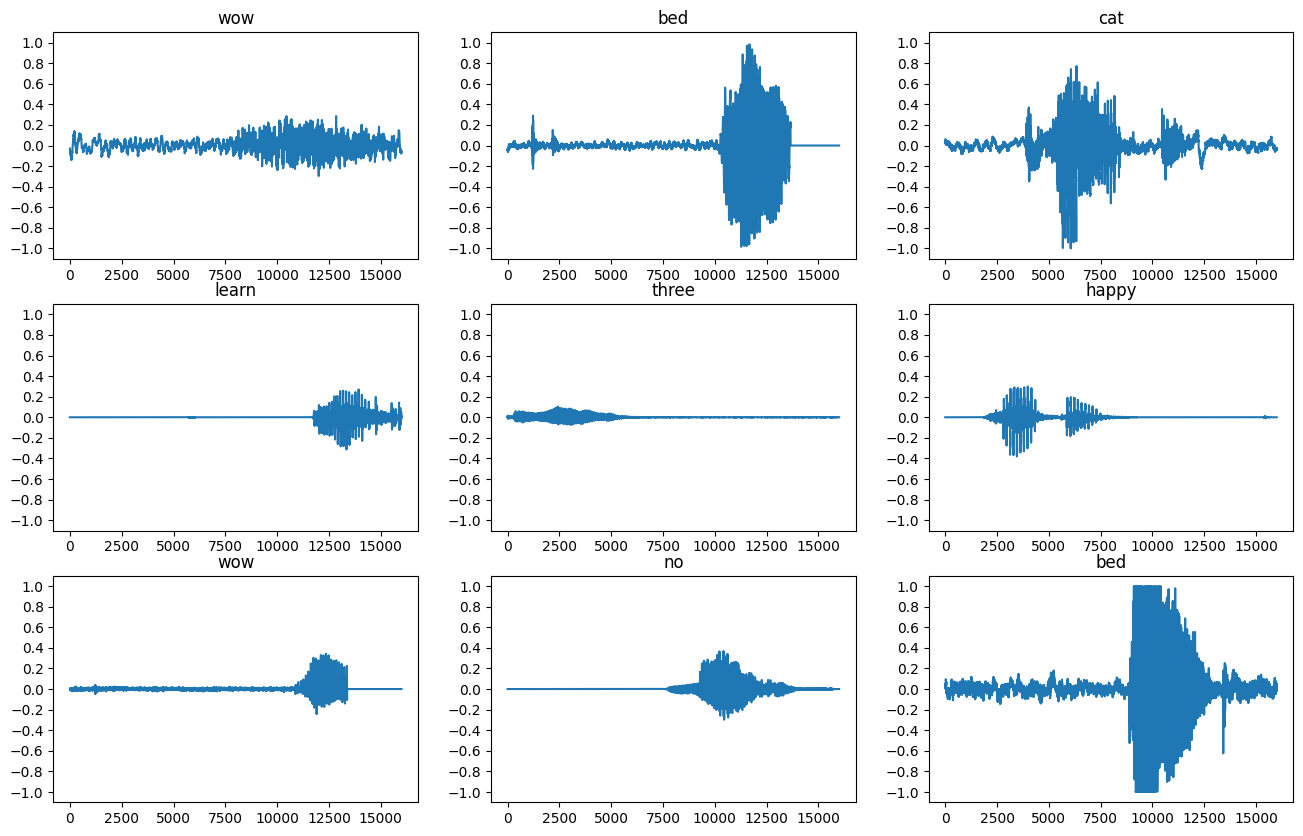

In [16]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fast Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [17]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [18]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: wow
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: bed
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: cat
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [19]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

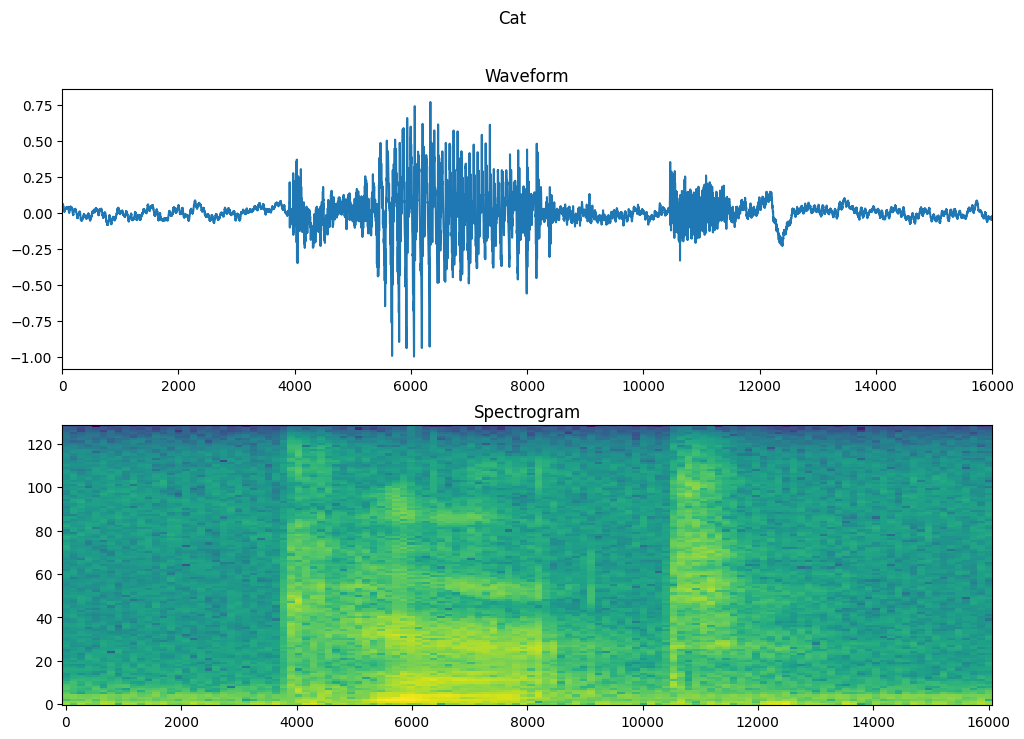

In [20]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [21]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [23]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

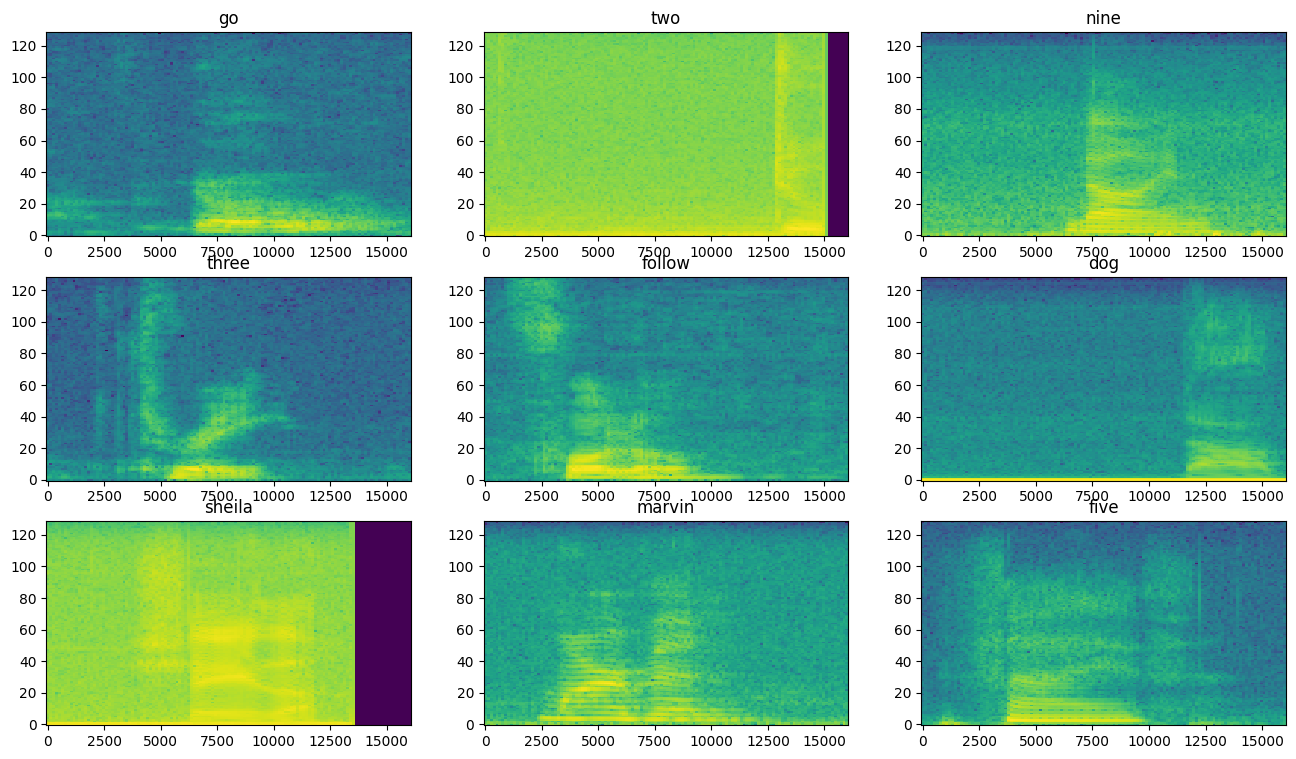

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [25]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, it is possible to use a Residual Network (ResNet) with 18 layers of convolutional neural networks (CNN), since the audio files has been transformed into spectrogram images.

The `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.BatchNormalization`: to normalize each pixel in the image based on its mean and standard deviation.
- `tf.keras.layers.Dropout`: to regularize the model and minimize over-fitting.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [26]:
from typing import List, Tuple
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

In [27]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.dp = layers.Dropout(0.35)
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        x = tf.nn.relu(x)
        out = self.dp(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [28]:
# set input image parameters
image_size = (129, 124)
channels = 1
num_classes = 36
print(image_size[1], image_size[0])

model = ResNet18(num_classes)
model.build(input_shape = (None,129,124,1))
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


124 129
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple      

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over a maximum of 80 epochs using Learning Rate decay to reduce the learning rate when the training is not improving the loss on the validation dataset and get a little extra improvement. Early stopping is also used to avoid (or minimize) over-fitting.

In [30]:
EPOCHS = 80
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.00002)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr_callback, early_stopping_callback])

# history = model.fit(
#     train_spectrogram_ds,
#     validation_data=val_spectrogram_ds,
#     epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
# )

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1561/1561 [==============================] - 335s 96ms/step - loss: 1.7365 - accuracy: 0.5009 - val_loss: 0.6022 - val_accuracy: 0.8191 - lr: 2.0000e-04
Epoch 2/80
1561/1561 [==============================] - 137s 88ms/step - loss: 0.5858 - accuracy: 0.8237 - val_loss: 0.4300 - val_accuracy: 0.8698 - lr: 2.0000e-04
Epoch 3/80
1561/1561 [==============================] - 136s 87ms/step - loss: 0.4196 - accuracy: 0.8721 - val_loss: 0.3368 - val_accuracy: 0.9029 - lr: 2.0000e-04
Epoch 4/80
1561/1561 [==============================] - 136s 87ms/step - loss: 0.3418 - accuracy: 0.8960 - val_loss: 0.3029 - val_accuracy: 0.9127 - lr: 2.0000e-04
Epoch 5/80
1561/1561 [==============================] - 136s 87ms/step - loss: 0.2905 - accuracy: 0.9113 - val_loss: 0.2739 - val_accuracy: 0.9234 - lr: 2.0000e-04
Epoch 6/80
1561/1561 [==============================] - 136s 87ms/step - loss: 0.2575 - accuracy: 0.9203 - val_loss: 0.2488 - val_accuracy: 0.9256 - lr: 2.0000e-04
Epoch 7/80
1561/1561 [=====

Let's plot the training and validation loss curves to check how your model has improved during training:

In [1]:
metrics = history.history
plt.figure(figsize=(21,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

NameError: ignored

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

50/50 [==============================] - 1s 28ms/step - loss: 0.1545 - accuracy: 0.9613


{'loss': 0.15448951721191406, 'accuracy': 0.9612500071525574}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

50/50 [==============================] - 2s 29ms/step


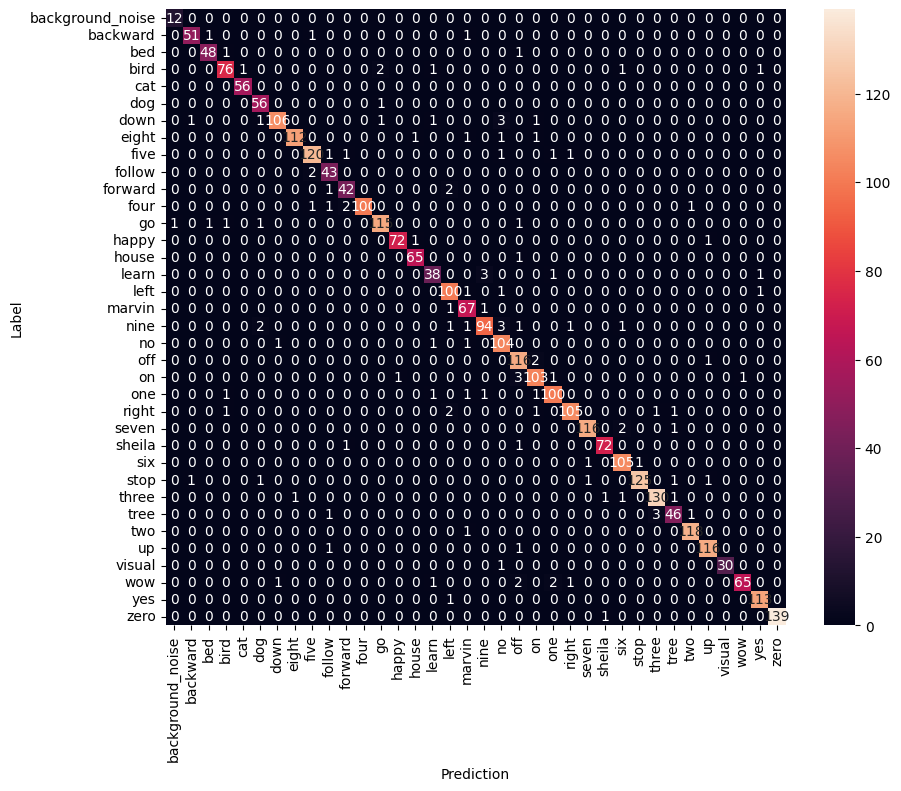

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

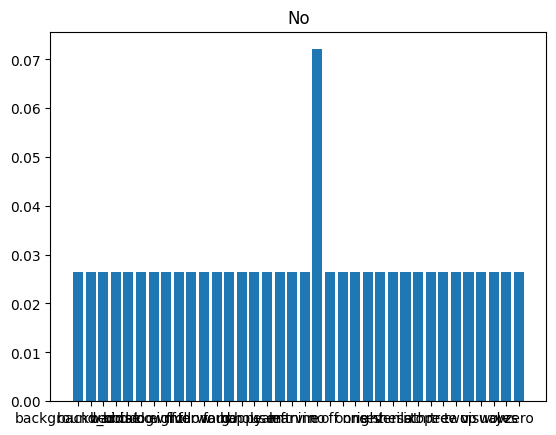

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
#x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
x_labels = ['background_noise', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[3.5210074e-20, 2.3985605e-12, 4.9559440e-13, 6.3174127e-12,
         2.4240880e-14, 1.6161692e-09, 1.7295934e-08, 1.3126293e-12,
         1.1557318e-12, 3.4788497e-10, 5.5024128e-13, 2.5882031e-13,
         2.3778068e-07, 1.3938759e-13, 1.1807463e-10, 3.6966669e-10,
         4.3212582e-13, 3.7789000e-10, 9.8591102e-07, 9.9999881e-01,
         8.1149329e-13, 1.5626535e-11, 2.2442961e-12, 4.3591914e-12,
         3.4075642e-13, 6.3741601e-14, 3.8251195e-15, 3.5794962e-14,
         2.5982153e-12, 8.6178088e-14, 2.8017916e-11, 6.2150896e-10,
         1.1910220e-10, 3.9709653e-09, 1.9672903e-12, 1.4880551e-10]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[3.5210074e-20, 2.3985605e-12, 4.9559440e-13, 6.3174127e-12,
         2.4240880e-14, 1.6161692e-09, 1.7295934e-08, 1.3126293e-12,
         1.1557318e-12, 3.4788497e-10, 5.5024128e-13, 2.5882031e-13,
         2.3778068e-07, 1.3938759e-13, 1.1807463e-10, 3.6966669e-10,
         4.3212582e-13, 3.7789000e-10, 9.8591102e-07, 9.9999881e-01,
         8.1149329e-13, 1.5626535e-11, 2.2442961e-12, 4.3591914e-12,
         3.4075642e-13, 6.3741601e-14, 3.8251195e-15, 3.5794962e-14,
         2.5982153e-12, 8.6178088e-14, 2.8017916e-11, 6.2150896e-10,
         1.1910220e-10, 3.9709653e-09, 1.9672903e-12, 1.4880551e-10]],
       dtype=float32)>}

In [ ]:
model.save_weights("model_weights.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Select the route inside your personal Google Drive folder where you whant to save this model's weights.

In [ ]:
!cp -r "model_weights.h5" "/content/drive/MyDrive/<your_route>/audio_commands_recognition_35_lables.h5"

This is the TensorFlow version used. Take it into consideration when using this model.

In [ ]:
print(tf.__version__)

2.10.0


## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.